In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install catboost
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading data

In [3]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\\Users\\user\\Desktop\\DBC_predict\\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.00,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.00,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.00,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.00,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.00,6743


In [207]:
w = pd.read_excel(r'C:\\Users\\user\\Desktop\\DBC_predict\\w.xlsx')
w = w[w['spot'] == '경기도']
w = w.sort_values('date')
w.rename(columns= {'date':'O_YMD'}, inplace=True)
w = w[(w['O_YMD'] < '2022-06-01')]

In [208]:
w.drop(['Unnamed: 0', 'spot'], axis=1, inplace=True)

In [209]:
w

,O_YMD,temp,rain,humid
9384,2019-12-31,-6.90,0.00,60.10
9385,2020-01-01,-2.20,0.00,79.30
9386,2020-01-02,1.30,0.00,83.30
9387,2020-01-03,-0.10,0.00,80.50
9388,2020-01-04,1.30,0.00,76.10
...,...,...,...,...
14824,2022-05-27,19.10,0.00,64.50
14835,2022-05-28,21.50,0.00,55.40
14843,2022-05-29,21.90,0.00,64.80
14850,2022-05-30,19.70,0.40,80.50


In [210]:
# 불필요한 컬럼들 제거
# Unnamed: 단순 데이터 순서를 나타내는 컬럼이기에 삭제
# O_YMD: 주문 시간은 오더 건수와 큰 상관이 없기에 삭제
# ORD_NO: 주문 내용의 일련번호이기에 삭제
# PKG_GOODS_NO: PKG_GOODS_NM과 내용이 겹치고 잘못 적재된 데이터이기에 삭제
# RECVR_ROAD_BASE_ADDR: 비대면으로 주문하는 시대에 지역정보는 큰 의미가 없을 것 같아 삭제
# 등등 미래에 예측할 수 없는 데이터는 모두 삭제

# 카피 데이터 생성
#copy_data = raw_data[['H_YMD', 'O_YMD', 'GOODS_NO', 'ORD_QTY', 'SALE_PRICE','REAL_ORD_QTY']]
copy_data = raw_data[['H_YMD', 'O_YMD', 'ORD_QTY', 'GOODS_NO', 'CANCEL_QTY', 'RET_QTY', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE', 'REAL_ORD_QTY']]

# 희망배송일 순서대로 데이터를 정렬
copy_data = copy_data.sort_values(by = 'H_YMD')

In [217]:
d1 = copy_data.set_index('O_YMD')
d2 = w.set_index('O_YMD')

d2
#pd.concat(d1, d2, join ='inner')

,temp,rain,humid
O_YMD,,,
2019-12-31,-6.90,0.00,60.10
2020-01-01,-2.20,0.00,79.30
2020-01-02,1.30,0.00,83.30
2020-01-03,-0.10,0.00,80.50
2020-01-04,1.30,0.00,76.10
...,...,...,...
2022-05-27,19.10,0.00,64.50
2022-05-28,21.50,0.00,55.40
2022-05-29,21.90,0.00,64.80


### 파이프라인

In [16]:
GOODS_DIC = {1712010310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', 14985:'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

In [21]:
def GOODS(df, gn):
  # 상품의 번호가 들어오면 해당 제품 코드를 반환
  df = df[df['GOODS_NO'] == gn]

  return df

In [18]:
def ADD_DATETIME(df):
    # 희망배송일의 연도,월,일 데이터를 각각 year, month, day 변수에 넣어준다.

    df['H_YMD'] = pd.to_datetime(df['H_YMD'])
    df['year'] = df['H_YMD'].dt.year
    df['month'] = df['H_YMD'].dt.month
    df['day'] = df['H_YMD'].dt.day

    return df

In [120]:
def SHIFT(df):
    df['ord_qty_day']  = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['ORD_QTY'].shift(4)
    df['sale_price_shift']  = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['SALE_PRICE'].shift(4)
    df['cancel_qty_shift']  = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['CANCEL_QTY'].shift(4)
    df['ret_qty_shift']  = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['RET_QTY'].shift(4)
    df['discount_shift']  = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['DISCOUNT_AMT'].shift(4)
    df['final_price_shift']  = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['FINAL_PRICE'].shift(4)
    #df['resl_ord_shift']  = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['RAEL_ORD_QTY'].shift(6)
    

    return df

In [119]:
def FE(df):
    # 판매가격 구성단위 변수 생성
    # 판매가격을 최종 주문건수르 나눈 item_price_unit 변수를 생성한다.
    df['item_price_unit'] = df['sale_price_shift'] // df['ord_qty_day']
    df['item_price_unit'].fillna(0, inplace=True)

    # 각 제품의 최솟값과 최댓값을 변수로 넣어준다.(가격별 상승, 하강 추이를 파악하기 위해)
    gp_item_price = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'], as_index=False).agg({'sale_price_shift':[np.min, np.max]})
    gp_item_price.columns = ['O_YMD', 'GOODS_NO', 'hist_min_item_price', 'hist_max_item_price']
    df = pd.merge(df, gp_item_price, on=['O_YMD','GOODS_NO'], how='left')

    # 판매액에서 최솟값을 빼 상승값으로 넣어주고
    # 판매액에서 최댓값을 빼 하강값으로 넣어준다.
    df['price_increase'] = df['sale_price_shift'] - df['hist_min_item_price']
    df['price_decrease'] = df['hist_max_item_price'] - df['sale_price_shift']

    return df

In [236]:
def ROLLING(df):
    # 몇개의 데이터를 가지고 연산을 할 것인가
    # 데이터들을 순차적으로 7일 (window=7)씩 선택해서 mean처럼 이동평균을 냄
    # 3일치의 min,max,std도 고려할 수 있습니다. 

    # Min value
    f_min = lambda x: x.rolling(window=6, min_periods=1).min()
    # Max value
    f_max = lambda x: x.rolling(window=6, min_periods=1).max()
    # Mean value
    f_mean = lambda x: x.rolling(window=6, min_periods=1).mean()
    # Standard deviation
    f_std = lambda x: x.rolling(window=6, min_periods=1).std()

    function_list = [f_min, f_max, f_mean, f_std]
    function_name = ['min', 'max', 'mean', 'std']

    for i in range(len(function_list)):
        #df[('ORD_QTY_shifted_%s' % function_name[i])] = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['ord_qty_day'].apply(function_list[i])
        df[('ORD_QTY_shifted_%s' % function_name[i])] = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['ORD_QTY'].apply(function_list[i])
    # Fill the empty std features with 0
    df['ORD_QTY_shifted_std'].fillna(0, inplace=True)
    
    return df

In [219]:
def LAG(df):
    # 시점을 1일, 2일, 3일로 미뤄서 lag 변수를 생성해준다.

    lag_list = [6,12,18]

    for lag in lag_list:
        ft_name = ('ORD_QTY_shifted%s' % lag)
        #train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(lag)
        df[ft_name] = df.sort_values('H_YMD').groupby(['O_YMD', 'GOODS_NO'])['ORD_QTY'].shift(lag)
        # Fill the empty shifted features with 0
        df[ft_name].fillna(0, inplace=True)

    return df

In [255]:
def TREND(df):
    # lag 시켰을 때 나온 item_count 판매량을 lag로 나눠서 1을 더해준다.
    lag_list = [6,12,18]
    df['item_trend'] = df['ord_qty_day']

    for lag in lag_list:
        ft_name = ('ORD_QTY_shifted%s' % lag)
        df['item_trend'] -= df[ft_name]

    df['item_trend'] /= len(lag_list) + 1

    return df

In [116]:
def MEAN_DATA(df):
    # 학습데이터의 상품번호 별 일별 판매량 평균
    gp_goods_mean = df.groupby(['O_YMD','GOODS_NO']).agg({'ord_qty_day': ['mean']})
    gp_goods_mean.columns = ['GOODS_mean']
    gp_goods_mean.reset_index(inplace=True)


    # 핛습데이터의 연도별 일별 판매량 평균
    gp_year_mean = df.groupby(['year']).agg({'ord_qty_day': ['mean']})
    gp_year_mean.columns = ['year_mean']
    gp_year_mean.reset_index(inplace=True)

    # 학습데이터의 월별 일별 판매량 평균
    gp_month_mean = df.groupby(['month']).agg({'ord_qty_day': ['mean']})
    gp_month_mean.columns = ['month_mean']
    gp_month_mean.reset_index(inplace=True)

    # 훈련 데이터에 판매량 평균 데이터들 결함
    df = pd.merge(df, gp_goods_mean, on=['O_YMD','GOODS_NO'], how='left')
    df = pd.merge(df, gp_year_mean, on=['year'], how='left')
    df = pd.merge(df, gp_month_mean, on=['month'], how='left')

    return df


In [102]:
# 결측치들을 상품번호별 중앙값으로 대체한다.

def REPLACE_MISSING_VALUE(df):
    # Replace missing values with the median of each shop.            
    for goods_no in df['GOODS_NO'].unique():
        for column in df.columns:
            goods_median = df[(df['GOODS_NO'] == goods_no)][column].median()
            df.loc[(df[column].isnull()) & (df['GOODS_NO'] == goods_no), column] = goods_median

    # Fill remaining missing values on test set with mean.
    df.fillna(df.mean(), inplace=True)
    
    return df 

In [221]:
def DBC_PIPELINE(df):
    temp = df.copy()
    
    temp = ADD_DATETIME(temp)

    temp = SHIFT(temp)

    temp = FE(temp)
    
    temp = ROLLING(temp)

    temp = LAG(temp)

    temp = TREND(temp)

    temp = MEAN_DATA(temp)

    temp = REPLACE_MISSING_VALUE(temp)

    return temp

### 데이터 분할

In [256]:
my_data= copy_data.copy()

my_data = my_data[my_data['H_YMD'] > '2020-01-05']

my_data

,H_YMD,O_YMD,ORD_QTY,GOODS_NO,CANCEL_QTY,RET_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE,REAL_ORD_QTY
168675,2020-01-06 00:00:00,2020-01-05 00:14:21,1,3273,0,0,4200,NaN,4200,1
167277,2020-01-06 00:00:00,2020-01-03 13:26:34,1,1712010310,0,0,6900,403.00,6497,1
174692,2020-01-06 00:00:00,2020-01-04 13:16:36,2,1808011751,0,0,8900,561.00,8339,2
167464,2020-01-06 00:00:00,2020-01-03 16:52:49,1,1805011121,0,0,5800,NaN,5800,1
171755,2020-01-06 00:00:00,2020-01-03 17:33:06,1,1808011751,0,0,8900,NaN,8900,1
...,...,...,...,...,...,...,...,...,...,...
236658,2022-05-31 00:00:00,2022-05-25 03:16:34,1,1803010879,0,0,4500,NaN,4500,1
241774,2022-05-31 00:00:00,2022-05-30 15:48:24,1,1909013359,0,0,9900,1801.00,8099,1
236656,2022-05-31 00:00:00,2022-05-29 15:45:30,1,1803010879,0,0,4500,NaN,4500,1
241810,2022-05-31 00:00:00,2022-05-30 15:54:40,1,1909013359,0,0,9900,1490.00,8410,1


In [257]:
# 데이터를 H_YMD(희망배송일), GOODS_NO(상품 번호)로 groupby를 해준다.
# SALE_PRICE(판매가격), ORD_QTY(주문 건수), REAL_ORD_QTY(최종주문건수)의 평균값과 매매거래량 변수를 만든다.


my_data['O_YMD'] = pd.to_datetime(my_data['O_YMD'])
my_data['O_YMD'] = my_data['O_YMD'].dt.weekday

# my_data = my_data.groupby(['H_YMD', 'O_YMD', 'GOODS_NO'], as_index=False)
# my_data = my_data.agg({
#                         'SALE_PRICE':['sum', 'mean'], 
#                         'ORD_QTY':['sum'],
#                         'REAL_ORD_QTY':['sum']
#                         })

# my_data.columns = [
#                     'H_YMD', 'O_YMD', 'GOODS_NO',
#                     'SALE_PRICE', 'mean_sale_price',
#                     'ORD_QTY',
#                     'REAL_ORD_QTY',
#                     ]

my_data = my_data.groupby(['H_YMD', 'O_YMD', 'GOODS_NO'], as_index=False)
my_data = my_data.agg({
                        'SALE_PRICE':['sum', 'mean'], 
                        'ORD_QTY':['sum'],
                        'REAL_ORD_QTY':['sum'],
                        'CANCEL_QTY':['sum'],
                        'RET_QTY':['sum'],
                        'DISCOUNT_AMT':['sum'],
                        'FINAL_PRICE':['sum']
                        })

my_data.columns = [
                    'H_YMD', 'O_YMD', 'GOODS_NO',
                    'SALE_PRICE', 'mean_sale_price',
                    'ORD_QTY',
                    'REAL_ORD_QTY',
                    'CANCEL_QTY',
                    'RET_QTY',
                    'DISCOUNT_AMT',
                    'FINAL_PRICE'
                    ]
    
# REAL_ORD_QTY 변수는 예측 불가 변수이기 때문에 해당 변수에서 파생된 변수들을 삭제한다
#my_data.drop(['mean_real_ord_qty'], axis=1, inplace=True)


In [258]:
my_data = GOODS(my_data, 14375)

my_data

,H_YMD,O_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,ORD_QTY,REAL_ORD_QTY,CANCEL_QTY,RET_QTY,DISCOUNT_AMT,FINAL_PRICE
2,2020-01-06 00:00:00,0,14375,25800,8600.00,3,1,2,0,0.00,25800
8,2020-01-06 00:00:00,1,14375,8600,8600.00,1,1,0,0,1967.00,6633
15,2020-01-06 00:00:00,2,14375,51600,8600.00,7,6,1,0,1638.00,49962
22,2020-01-06 00:00:00,3,14375,86000,8600.00,10,10,0,0,623.00,85377
34,2020-01-06 00:00:00,4,14375,352600,8600.00,44,43,1,0,5659.00,346941
...,...,...,...,...,...,...,...,...,...,...,...
59295,2022-05-31 00:00:00,2,14375,35200,8800.00,5,2,3,0,0.00,35200
59305,2022-05-31 00:00:00,3,14375,8800,8800.00,1,1,0,0,0.00,8800
59314,2022-05-31 00:00:00,4,14375,17600,8800.00,2,2,0,0,879.00,16721
59329,2022-05-31 00:00:00,5,14375,114400,8800.00,15,14,1,0,2511.00,111889


In [242]:
from sklearn.model_selection import train_test_split

my_data['H_YMD'] = pd.to_datetime(my_data['H_YMD'])

test_set =my_data[(my_data['H_YMD'].dt.year == 2022) & (my_data['H_YMD'].dt.month == 5)] # 2022년 5월 데이터를 테스트셋으로 설정

idx =my_data[(my_data['H_YMD'].dt.year == 2022) & (my_data['H_YMD'].dt.month == 5)].index # 2022년 5월 데이터의 인덱스 저장
my_data.drop(idx, inplace=True)

target = 'REAL_ORD_QTY'

Y = my_data[target]
X = my_data.drop(target, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=.2, shuffle=False, random_state=2022 )
y_test = test_set[target]
X_test = test_set.drop(target, axis=1)

### 파이프라인 가동

In [243]:
X_train = DBC_PIPELINE(X_train)
X_val = DBC_PIPELINE(X_val)
X_test = DBC_PIPELINE(X_test)


In [244]:
X_train = X_train[X_train['H_YMD'] >= '2020-01-05']
y_train = y_train[len(y_train)-len(X_train):]

In [245]:
len(X_train)

3751

In [246]:
X_train.columns

Index(['H_YMD', 'O_YMD', 'GOODS_NO', 'SALE_PRICE', 'mean_sale_price',
       'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'DISCOUNT_AMT', 'FINAL_PRICE',
       'year', 'month', 'day', 'ord_qty_day', 'sale_price_shift',
       'cancel_qty_shift', 'ret_qty_shift', 'discount_shift',
       'final_price_shift', 'item_price_unit', 'hist_min_item_price',
       'hist_max_item_price', 'price_increase', 'price_decrease',
       'ORD_QTY_shifted_min', 'ORD_QTY_shifted_max', 'ORD_QTY_shifted_mean',
       'ORD_QTY_shifted_std', 'ORD_QTY_shifted6', 'ORD_QTY_shifted12',
       'ORD_QTY_shifted18', 'item_trend', 'GOODS_mean', 'year_mean',
       'month_mean'],
      dtype='object')

In [247]:
# xgb_features = [
#                 'SALE_PRICE', 'mean_sale_price', 
#                 'ORD_QTY_shifted_min', 'ORD_QTY_shifted_max', 'ORD_QTY_shifted_mean',
#                 'ORD_QTY_shifted_std', 'ORD_QTY_shifted6', 'ORD_QTY_shifted13',
#                 'ORD_QTY_shifted20', 'item_trend', 'GOODS_mean'
#                 ]

xgb_features = [
                'mean_sale_price',
                'ord_qty_day', 'sale_price_shift', 'cancel_qty_shift',
                'ret_qty_shift', 'discount_shift', 'final_price_shift',
                'item_price_unit', 'hist_min_item_price', 'hist_max_item_price',
                'price_increase', 'price_decrease', 'ORD_QTY_shifted_min',
                'ORD_QTY_shifted_max', 'ORD_QTY_shifted_mean', 'ORD_QTY_shifted_std',
                'ORD_QTY_shifted6', 'ORD_QTY_shifted12', 'ORD_QTY_shifted18',
                'item_trend', 'GOODS_mean', 'year_mean', 'month_mean'
                ]

xgb_train = X_train[xgb_features]
xgb_val = X_val[xgb_features]
xgb_test = X_test[xgb_features]

In [248]:
xgb_model = XGBRegressor(max_depth=5, 
                         n_estimators=1000, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.1, 
                         seed=0)
xgb_model.fit(xgb_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, y_train), (xgb_val, y_val)], 
              verbose=20, 
              early_stopping_rounds=20)

[0]	validation_0-rmse:38.98922	validation_1-rmse:39.98351
[20]	validation_0-rmse:27.53142	validation_1-rmse:28.75606
[40]	validation_0-rmse:26.61425	validation_1-rmse:27.73620
[60]	validation_0-rmse:26.17628	validation_1-rmse:27.27130
[80]	validation_0-rmse:25.85579	validation_1-rmse:26.86102
[100]	validation_0-rmse:25.62468	validation_1-rmse:26.59700
[120]	validation_0-rmse:25.42455	validation_1-rmse:26.35639
[140]	validation_0-rmse:25.25522	validation_1-rmse:26.20822
[160]	validation_0-rmse:25.11267	validation_1-rmse:26.01520
[180]	validation_0-rmse:24.99427	validation_1-rmse:25.87848
[200]	validation_0-rmse:24.89264	validation_1-rmse:25.74913
[220]	validation_0-rmse:24.81446	validation_1-rmse:25.64362
[240]	validation_0-rmse:24.74170	validation_1-rmse:25.57670
[260]	validation_0-rmse:24.68136	validation_1-rmse:25.47242
[280]	validation_0-rmse:24.62529	validation_1-rmse:25.42813
[300]	validation_0-rmse:24.58201	validation_1-rmse:25.42081
[320]	validation_0-rmse:24.53954	validation_1-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1000,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [132]:
import joblib

joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

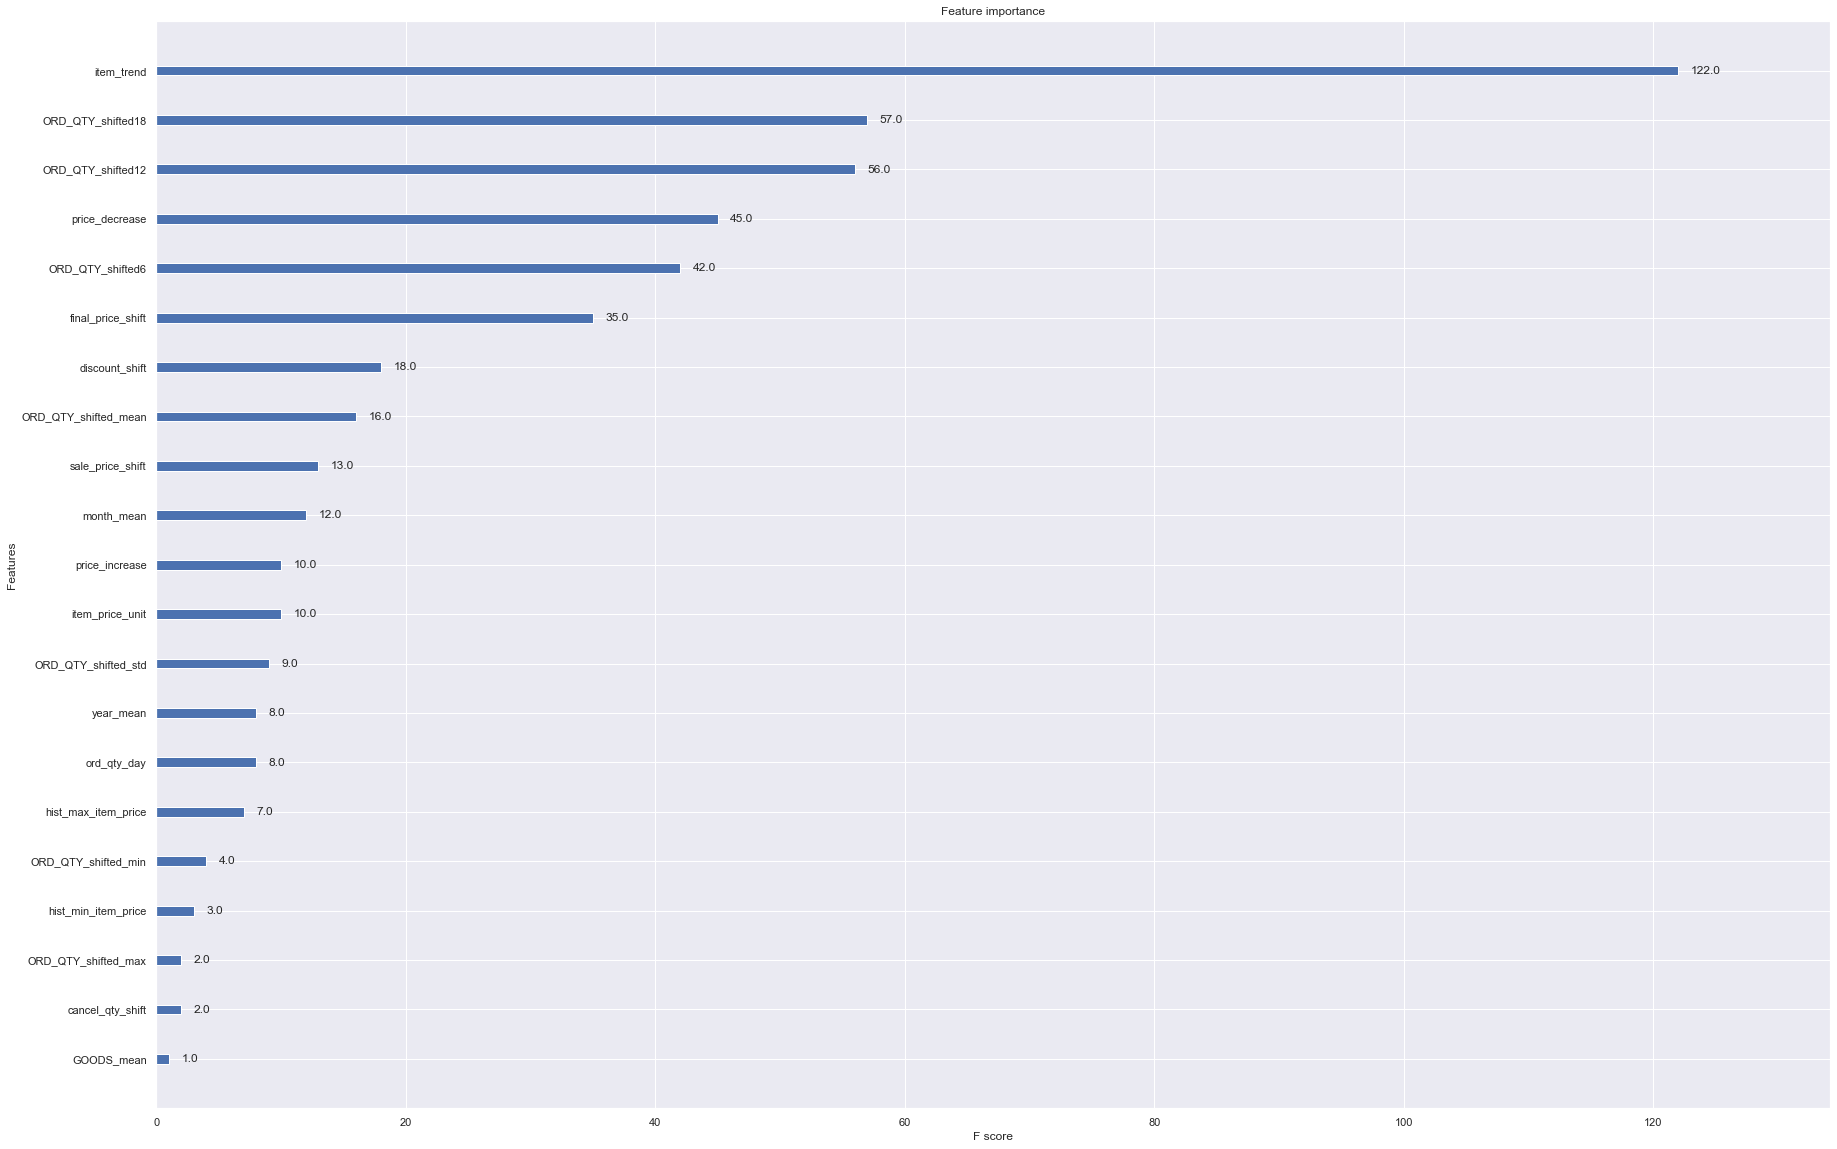

In [249]:
plt.rcParams["figure.figsize"] = (30, 20)
plot_importance(xgb_model)
plt.show()

In [250]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [251]:
from sklearn.metrics import r2_score

print('r2:', r2_score(y_test, xgb_test_pred))
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, xgb_val_pred)))

r2: 0.33041719284671334
Train rmse: 24.372669105686327
Validation rmse: 25.12900441290925


In [313]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {1712010310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', 14985:'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

In [135]:
def to_csv(predict, x_test, y_test):
    predict = pd.DataFrame(predict)
    predict['H_YMD'] = x_test['H_YMD'][-(len(x_test)):]
    predict['GOODS_NO'] = x_test['GOODS_NO']
    
    y_test = pd.DataFrame(y_test)
    y_test.reset_index(drop=True, inplace=True)
    y_test['H_YMD'] = x_test['H_YMD'][-(len(x_test)):]
    y_test['GOODS_NO'] = x_test['GOODS_NO']
    
    for n in GOODS_DIC.keys():
        predict['GOODS_NO'].loc[predict['GOODS_NO'] == n ] = GOODS_DIC[n]
        y_test['GOODS_NO'].loc[y_test['GOODS_NO'] == n ] = GOODS_DIC[n]

    
    predict.columns = ['REAL_ORD_QTY',  'H_YMD', 'GOODS_NM']
    y_test.columns = ['REAL_ORD_QTY',  'H_YMD', 'GOODS_NM']

    predict = predict.groupby(['H_YMD', 'GOODS_NM'])
    predict = predict.sum()

    y_test = y_test.groupby(['H_YMD','GOODS_NM'])
    y_test = y_test.sum()

    return predict, y_test

In [136]:
xgb_result, y_result = to_csv(xgb_test_pred, X_test, y_test)

y_result.to_csv('C:\\Users\\user\\Desktop\\y_result.csv', encoding='utf-8-sig')
xgb_result.to_csv('C:\\Users\\user\\Desktop\\xgb_result.csv', encoding='utf-8-sig')


In [137]:
xgb_result[0:20]

,,REAL_ORD_QTY
H_YMD,GOODS_NM,
2022-05-02,옛날잡채(500g),138.06
2022-05-03,옛날잡채(500g),91.74
2022-05-04,옛날잡채(500g),99.71
2022-05-05,옛날잡채(500g),91.61
2022-05-06,옛날잡채(500g),141.41
2022-05-07,옛날잡채(500g),136.47
2022-05-09,옛날잡채(500g),125.61
2022-05-10,옛날잡채(500g),116.41
2022-05-11,옛날잡채(500g),103.65


In [138]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [252]:
X_train = X_train[xgb_features]
X_val = X_val[xgb_features]

In [253]:
def evaluate_regr(y, pred):
    mse = mean_squared_error(y, pred)
    rmse_val = np.sqrt(mse)
    mae_val = mean_absolute_error(y, pred)
    r2 = r2_score(y, pred)
    print('RMSE : {} | MAE : {} | r2 : {} '.format(round(rmse_val,5),round(mae_val,5),round(r2,5)))

# 여러 모델의 성능 확인 함수 
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
#--------------------------------------------------------------------
#모델별로 평가 확인 

ridge_reg = Ridge(alpha=0)      # best alpha = 0
lasso_reg = Lasso(alpha=1)        # best alpha = 1
tree_reg = DecisionTreeRegressor(random_state=13)
forest_reg = RandomForestRegressor(n_estimators=100,random_state=13)

for model in [ridge_reg, lasso_reg,tree_reg,forest_reg]:
# for model in [forest_reg]:
    get_model_predict(model, X_train, X_val, y_train, y_val)

### Ridge ###
RMSE : 12.83456 | MAE : 3.27573 | r2 : 0.85094 
### Lasso ###
RMSE : 1.96874 | MAE : 1.25999 | r2 : 0.99649 
### DecisionTreeRegressor ###
RMSE : 20.93115 | MAE : 11.53092 | r2 : 0.60354 
### RandomForestRegressor ###
RMSE : 13.94659 | MAE : 8.062 | r2 : 0.82399 


In [254]:
pd.DataFrame([X_train.columns, ridge_reg.coef_]).T

,0,1
0,mean_sale_price,-0.00
1,ord_qty_day,-0.03
2,sale_price_shift,0.08
3,cancel_qty_shift,-0.02
4,ret_qty_shift,-0.00
5,discount_shift,-0.08
6,final_price_shift,-0.08
7,item_price_unit,-0.00
8,hist_min_item_price,-0.00
9,hist_max_item_price,-0.00
